In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime as dt
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

In [2]:
df = pd.read_csv('/Users/YifanSun/Downloads/data.csv', encoding="latin-1")

# EDA

In [3]:
# check dimensions of the dataset
df.shape

(107578, 18)

In [4]:
df.columns

Index(['artist_birth_year', 'artist_death_year', 'artist_name',
       'artist_nationality', 'auction_date', 'category', 'currency', 'edition',
       'estimate_high', 'estimate_low', 'hammer_price', 'location',
       'materials', 'measurement_depth_cm', 'measurement_height_cm',
       'measurement_width_cm', 'title', 'year_of_execution'],
      dtype='object')

In [5]:
df['hammer_price'].describe()

count    1.012540e+05
mean     8.765909e+04
std      5.898940e+05
min     -1.000000e+00
25%      3.000000e+03
50%      1.200000e+04
75%      4.250000e+04
max      7.850000e+07
Name: hammer_price, dtype: float64

The minimum price is smaller than zero, should leave out when training the model

C:\Users\YifanSun\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


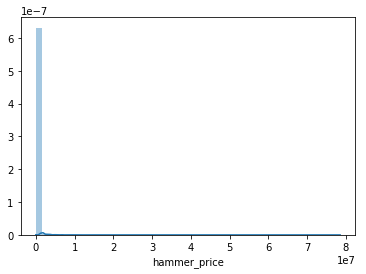

In [6]:
# get only valid data df2, with positive price
df1 = df[np.isfinite(df['hammer_price'])]
df2 = df1[(df1['hammer_price'] > 0)]
sns.distplot(df2['hammer_price'])

We can see that the price:
    1. Deviate from the normal distribution
    2. Have appreciable positive skewness (skew to the right)
    3. Have peakedness

In [7]:
# check distribution, skewness and kurtosis for hammer_price
print("Skewness: %f" % df2['hammer_price'].skew())
print("Kurtosis: %f" % df2['hammer_price'].kurt())

Skewness: 59.378420
Kurtosis: 6158.048880


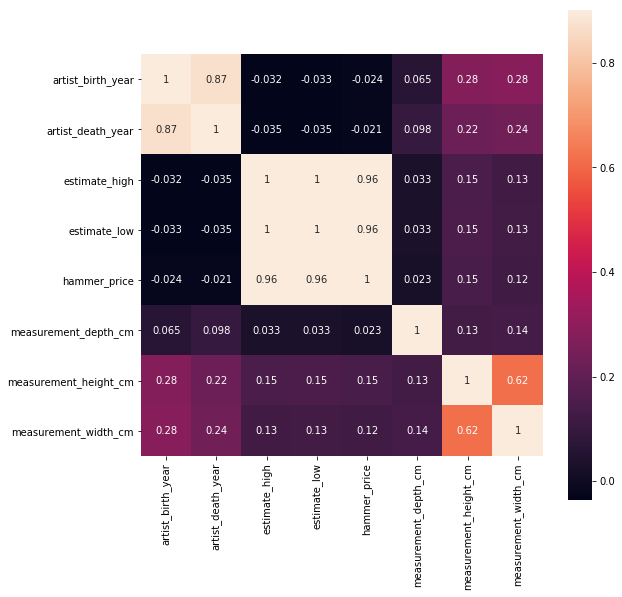

In [8]:
# check the correlation matrix to see how numeric variables are related to target and also multicollinearity 
corrmat = df2.corr()
plt.subplots(figsize=(9,9))
sns.heatmap(corrmat, vmax=0.9, annot=True, square=True)
plt.show()

"estimate_low" and "estimate_high" with absoulute correlation, which can indicate a situation of multicollinearity, as well as "artist_birth_year" and "artist_death_year"

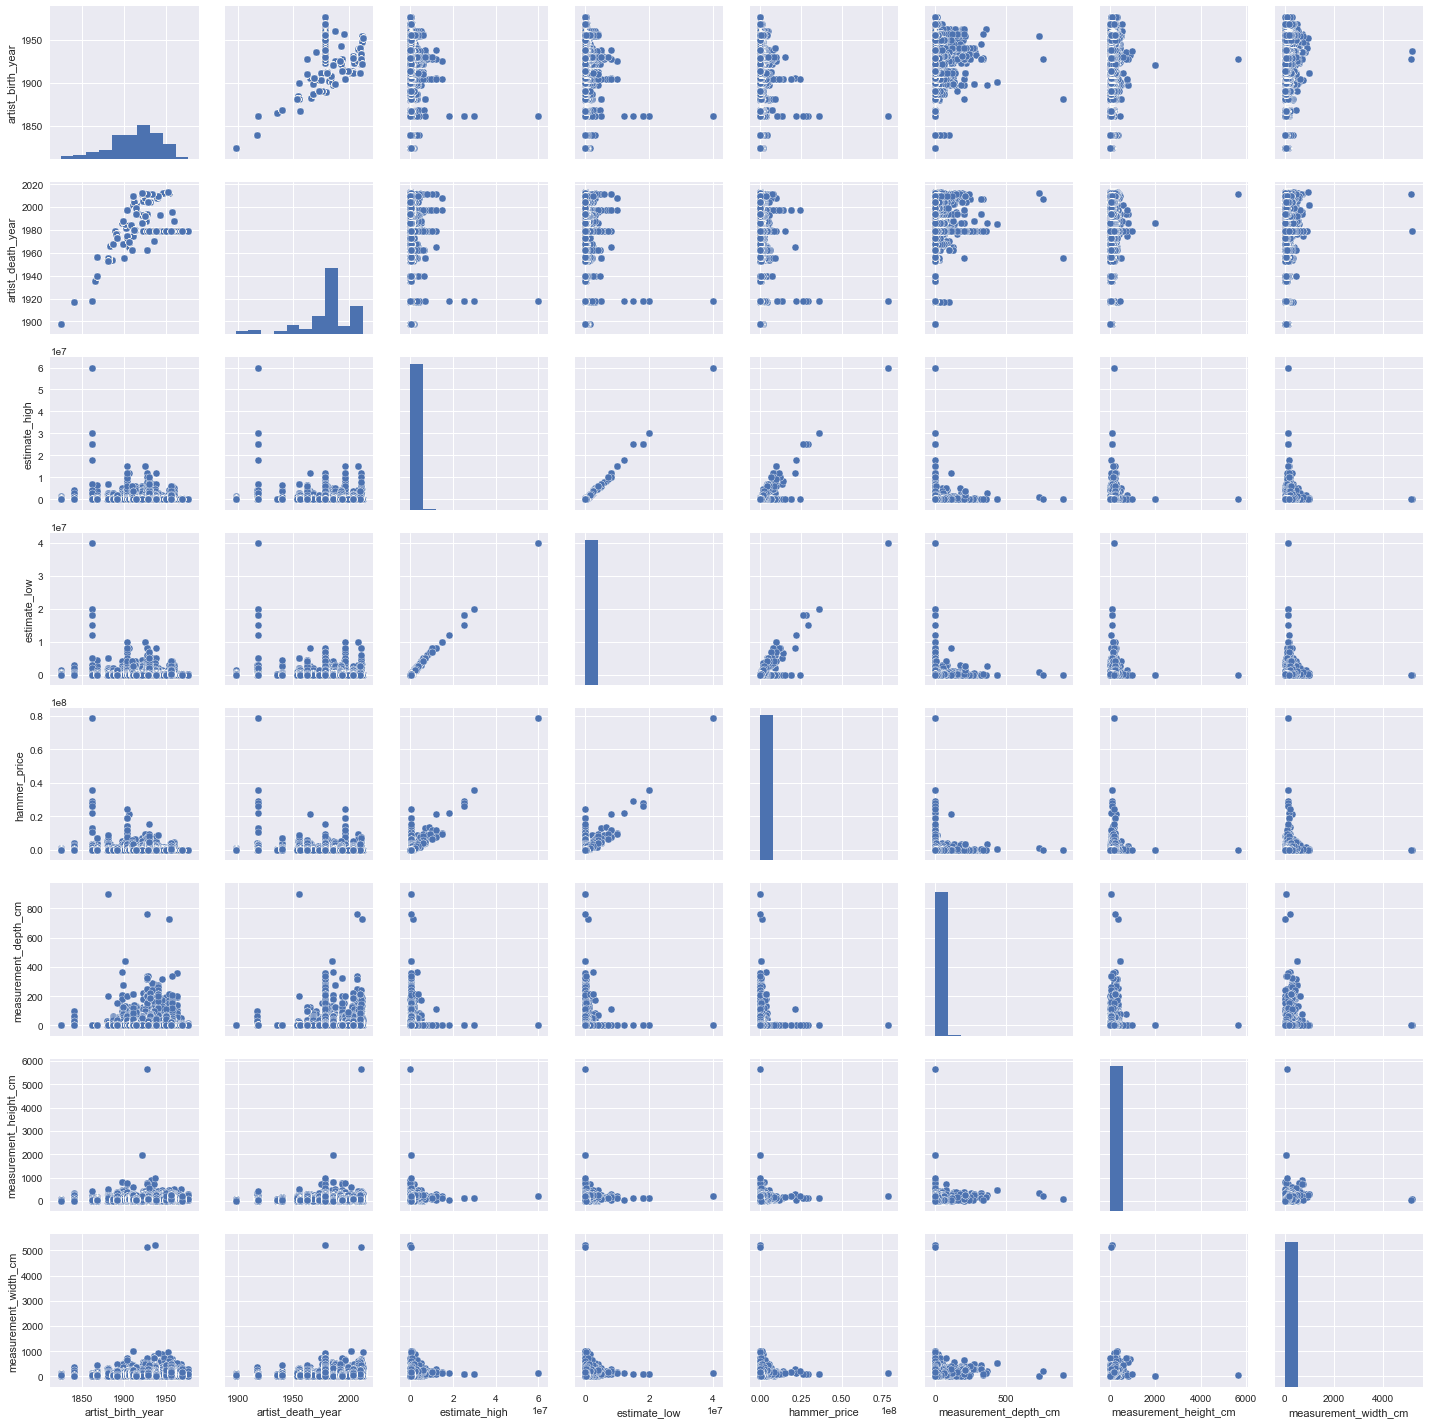

In [16]:
#scatterplot:  run this 
sns.set()
cols = ['artist_birth_year', 'artist_death_year', 'estimate_high',
       'estimate_low', 'hammer_price', 'measurement_depth_cm',
       'measurement_height_cm', 'measurement_width_cm']
sns.pairplot(df[cols], size = 2.5)
plt.show();

## Missing data
1. How prevalent is the missing data
2. Is missing data random or does it have a pattern?

In [9]:
# calculate missing data ratio after dropping the invalid hamemr_price
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)
pd.DataFrame({'Missing ratio' :df_na})

,Missing ratio
edition,87.566231
estimate_high,36.414509
estimate_low,36.409861
artist_death_year,33.828478
year_of_execution,25.804533
location,16.587964
hammer_price,5.878525
materials,1.709457
title,0.427597


Consider that when more than 15% of the data is missing, we should delete the corresponding variable. According to this, "edition" and "year_of_execution" should be deleted

## Outliers
Univariate analysis: establish a threshold that defines an oberservation as an outlier

In [10]:
#standardizing data
price_scaled = StandardScaler().fit_transform(df2['hammer_price'][:,np.newaxis]);
low_range = price_scaled[price_scaled[:,0].argsort()][:10]
high_range= price_scaled[price_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.15696197]
 [-0.15696197]
 [-0.15693212]
 [-0.15691603]
 [-0.15691603]
 [-0.15690155]
 [-0.15689995]
 [-0.15689995]
 [-0.15689995]
 [-0.15689995]]

outer range (high) of the distribution:
[[ 38.77914627]
 [ 41.67522061]
 [ 41.67522061]
 [ 44.89308099]
 [ 44.89308099]
 [ 47.30647627]
 [ 57.7645225 ]
 [ 57.7645225 ]
 [126.14405552]
 [126.14405552]]


1. Low range values are similar and not too far from 0.
2. High range values are far from 0 and 126.XXX values are really out of range

I'll not consider any of these values as an outlier but be careful with two 126.XXX values.

## Bivariate analysis

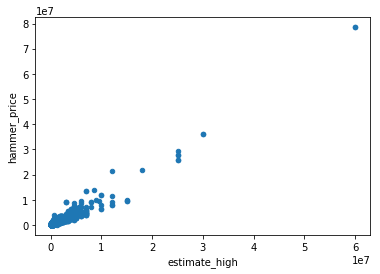

In [11]:
# scatter plot estimate high/hammer price
var = 'estimate_high'
data = pd.concat([df['hammer_price'], df2[var]], axis=1)
data.plot.scatter(x=var, y='hammer_price')

The value on the upper right corner is clearly a outlier, and these are the 126.XXX values that we should be careful about.
However, they seem to be following the trend. For this reason, I will keep them.

# Data preparation

In [12]:
# dummy the location variable first given test and train has different size of category

# Fill missing data with the word "Missing"
df2['location'].fillna("Missing", inplace=True)
# Create dummy variables
dummies = pd.get_dummies(df2['location'], prefix='location')
# Update x to include dummies and drop the original variables
df = pd.concat([df2, dummies], axis=1)
df.drop(['location'], axis=1, inplace=True)

C:\Users\YifanSun\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [13]:
df['auction_date'] =  pd.to_datetime(df['auction_date'], format='%Y-%m-%d')
# since auction_date share the same format, convert to numeric
df['auction_date'] = df['auction_date'].map(dt.datetime.toordinal)

In [14]:
## Imputing missing values
# the missing 'artist_death_year' should fill in with the current year
df.loc[:,'artist_death_year'].fillna(2018, inplace=True)

In [15]:
# For estimate data, since it's highly skewed, using median instead
median_list = df[['estimate_high', 'estimate_low']]
fill_NaN = Imputer(missing_values=np.nan, strategy='median', axis=0)
imputed_DF = pd.DataFrame(fill_NaN.fit_transform(median_list))
imputed_DF.columns = median_list.columns

In [16]:
# Assign the filled data to the dataframe
df = df.reset_index(drop=True)
for col in median_list.columns:
    df[col] = imputed_DF[col]

In [17]:
# Get new categorical, exclude location, which has already been dummies
categorical_variables2 = ['artist_name',
 'artist_nationality',
 'category',
 'currency']

In [18]:
# Get dummies for the other categorical vars
for variable in categorical_variables2:
    # Fill missing data with the word "Missing"
    df[variable].fillna("Missing", inplace=True)
        # Create dummy variables
    dummies = pd.get_dummies(df[variable], prefix=variable)
        # Update x to include dummies and drop the original variables
    df = pd.concat([df, dummies], axis=1)
    df.drop([variable], axis=1, inplace=True)

In [19]:
# For the rest categorical vars ['edition', 'materials', 'title', 'year_of_execution']
# show descritptive stats for categorical value
def describe_cat(x):
    display(HTML(x[x.columns[x.dtypes == 'object']].describe().to_html()))

describe_cat(df)

,edition,materials,title,year_of_execution
count,7688,89972,90935,65895
unique,5064,8295,29915,642
top,unique,Works on Paper,Untitled,1969
freq,32,20334,10839,1799


In [20]:
# Given the number of unique category are too large, dropping out these four vars
df = df.drop(['edition', 'materials', 'title', 'year_of_execution'], axis=1)

## Split test and train dataset

In [21]:
# Split the data into training and testing sets
y = np.log(df['hammer_price'])
x = df.drop('hammer_price', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [22]:
print('Training Features Shape:', x_train.shape)
print('Training Prices Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Prices Shape:', y_test.shape)

Training Features Shape: (68235, 371)
Training Prices Shape: (68235,)
Testing Features Shape: (22745, 371)
Testing Prices Shape: (22745,)


## Train Model and make predictions on the test set

In [23]:
# Fit Random Forest Model
# To save running time, only take in 50 estimators
RFmodel = RandomForestRegressor(50, oob_score=True, n_jobs=-1, min_samples_leaf=1, random_state=42)
RFmodel.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [24]:
# Predict y by x_test with RF model
# print output for y_train as predicted price of each row in test dataset
y_predicted = RFmodel.predict(x_test)
output = pd.DataFrame(y_predicted, columns = ['y_train'])

In [25]:
# get RMSE for RF model 
RMSE = sqrt(mean_squared_error(y_test, y_predicted))
print(RMSE)

0.45826202618002493


# Feature Importance

In [26]:
# viz all variables
feature_importances = pd.Series(RFmodel.feature_importances_, index=x.columns)

In [27]:
feature_importances.sort_values(ascending=False)[:20]

estimate_high                    0.446371
estimate_low                     0.124782
auction_date                     0.108390
measurement_height_cm            0.086104
measurement_width_cm             0.047231
location_New York                0.030127
artist_birth_year                0.025099
location_London                  0.017515
artist_death_year                0.013907
artist_nationality_American      0.007073
currency_GBP                     0.006097
artist_name_Andre Derain         0.005893
location_Missing                 0.005051
measurement_depth_cm             0.004641
artist_name_Man Ray              0.003875
artist_nationality_British       0.003272
artist_name_Willem de Kooning    0.002599
artist_nationality_French        0.002469
artist_name_Henry Moore          0.002158
artist_name_Cy Twombly           0.001622
dtype: float64

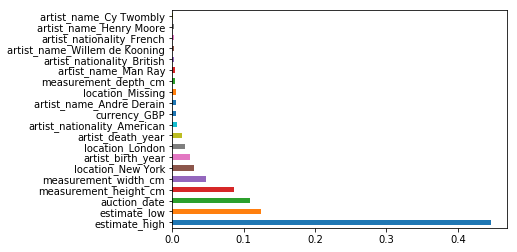

In [28]:
# Since has 371 features, only plot first 20 important features
feature_importances.sort_values(ascending=False)[:20].plot(kind='barh')
plt.show()

Interesting findings:
1. auction location in New York and London
2. American, British and French artist
3. Andre Derain
rank the top most important features among 372 variables.

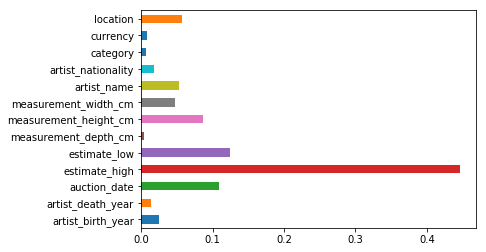

In [29]:
# Since dummies spreading all categorical variables, need to integrate again as one feature
# function for showing the summary

def summary_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    # True autoscale would automatically adjust the x size to the largest feature + headroom
    if autoscale:
        x_scale = model.feature_importances_.max() + headroom
    else:
        x_scale = 1
        
    feature_dict = dict(zip(feature_names, model.feature_importances_))
    
    # The list of column prefixes to summarize on
    if summarized_columns:
        for col_name in summarized_columns:
            # sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            
            # remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)
            # finally, get the summarized field
            feature_dict[col_name] = sum_value
            
    results = pd.Series(list(feature_dict.values()), index=feature_dict.keys())
    results.sort_values()
    results.plot(kind="barh")

summary_feature_importances(RFmodel, x.columns, summarized_columns = categorical_variables2+['location'])
plt.show()

# Parameter tests

Before consider taking in the dropped-out categorical variables, test the parameters to train the model better

30 trees
RMSE 0.4245063465259902

50 trees
RMSE 0.41372869195067397

100 trees
RMSE 0.4065543168509428

200 trees
RMSE 0.4030358717490222

500 trees
RMSE 0.40103125370202847

1000 trees
RMSE 0.40026162743627003

2000 trees
RMSE 0.4000770191458066



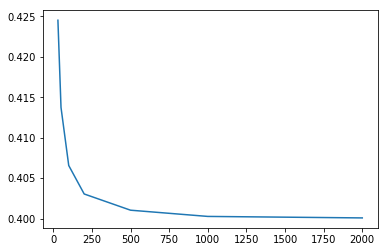

In [30]:
### n_estimators

results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model2 = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model2.fit(x, y)
    print (trees, "trees")
    RMSE = sqrt(mean_squared_error(y, model2.oob_prediction_))
    print ("RMSE", RMSE)
    results.append(RMSE)
    print ("")
    
pd.Series(results, n_estimator_options).plot()
plt.show()

auto features
RMSE:  0.4030358717490222

None features
RMSE:  0.4030358717490222

sqrt features
RMSE:  0.5972365369816796

log2 features
RMSE:  0.6291875941073821

0.9 features
RMSE:  0.40323648806024204

0.2 features
RMSE:  0.4956644987501784



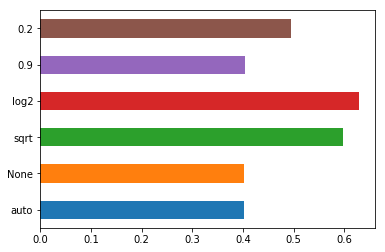

In [33]:
### max_features: number of features take into the model
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model2 = RandomForestRegressor(200, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model2.fit(x, y)
    print (max_features, "features")
    RMSE = sqrt(mean_squared_error(y, model2.oob_prediction_))
    print ("RMSE: ", RMSE)
    results.append(RMSE)
    print ("")
    
pd.Series(results, max_features_options).plot(kind="barh")
plt.show()

In [ ]:
### min_samples_leaf
results = []
min_samples_leaf_options = [1,2,3,4,5,6,7,8,9,10]

for min_samples in min_samples_leaf_options:
    model2 = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42, max_features='auto', min_samples_leaf=min_samples)
    model2.fit(x, y)
    print (min_samples, "min_samples")
    RMSE = sqrt(mean_squared_error(y, model2.oob_prediction_))
    print ("RMSE: ", RMSE)
    results.append(RMSE)
    print ("")
    
pd.Series(results, min_samples_leaf_options).plot()

# Output for min_samples_leaf
1 min_samples
RMSE:  0.40045780838613515

2 min_samples
RMSE:  0.4231435772780872

3 min_samples
RMSE:  0.445645520354724

4 min_samples
RMSE:  0.4681936943681546

5 min_samples
RMSE:  0.4884725948008925

6 min_samples
RMSE:  0.5063083571221659

7 min_samples
RMSE:  0.5219843677797569

8 min_samples
RMSE:  0.5360532301543444

9 min_samples
RMSE:  0.5486828723306593

10 min_samples
RMSE:  0.5600256068851456

From the RMSE result above, the best-case scenario would be no less than 0.4
To tune the parameter and save the running time meanwhile, plug in all optimized parameters to RF model3, where n_estimators = 200, max_features = 'auto', min_sample_leaf = 1

In [37]:
model_opt = RandomForestRegressor(n_estimators=1000, 
                               oob_score=True, 
                               n_jobs=-1, 
                               random_state=42, 
                               max_features='auto', 
                               min_samples_leaf=1)
model_opt.fit(x, y)
RMSE = sqrt(mean_squared_error(y, model_opt.oob_prediction_))
print ("RMSE: ", RMSE)

RMSE:  0.40026162743627003


RMSE metrics improves from initial 0.458 to 0.400